# ***Encoder-Decoder Model***

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import re
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

2023-03-18 19:34:01.460029: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-18 19:34:34.440889: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-18 19:34:34.441429: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-18 19:34:34.441481: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

---
## **Dataset**

In [2]:
lines= pd.read_table('datasets/por-eng/por.txt', names=['eng', 'por', '_'])
lines.shape

(188206, 3)

In [3]:
lines.sample(5)

,eng,por,_
60633,I can't find my glasses.,Não consigo achar os meus óculos.,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
108159,Tom denied writing the letter.,Tom negou que escreveu a carta.,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
108694,Tom knocked on the front door.,Tom bateu na porta da frente.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
172679,There are many Japanese restaurants in Boston.,Há muitos restaurantes japoneses em Boston.,CC-BY 2.0 (France) Attribution: tatoeba.org #6...
47548,I want to see a movie.,Eu quero assistir a um filme.,CC-BY 2.0 (France) Attribution: tatoeba.org #4...


In [4]:
# Lowercase all characters
lines.eng=lines.eng.apply(lambda x: x.lower())
lines.por=lines.por.apply(lambda x: x.lower())

# Remove quotes
lines.eng=lines.eng.apply(lambda x: re.sub("'", '', x))
lines.por=lines.por.apply(lambda x: re.sub("'", '', x))
exclude = set(string.punctuation) # Set of all special characters

# Remove all the special characters
lines.eng=lines.eng.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines.por=lines.por.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
lines.eng=lines.eng.apply(lambda x: x.translate(remove_digits))
lines.por = lines.por.apply(lambda x: x.translate(remove_digits))

# Remove extra spaces
lines.eng=lines.eng.apply(lambda x: x.strip())
lines.por=lines.por.apply(lambda x: x.strip())
lines.eng=lines.eng.apply(lambda x: re.sub(" +", " ", x))
lines.por=lines.por.apply(lambda x: re.sub(" +", " ", x))

# Add start and end tokens to target sequences
lines.por = lines.por.apply(lambda x : 'START_ '+ x + ' _END')

lines.sample(5)

,eng,por,_
25726,youd better come,START_ é melhor você vir _END,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
143117,the door opened and a man walked in,START_ a porta se abriu e um homem entrou _END,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
107134,one of the windows was broken,START_ uma das janelas estava quebrada _END,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
141619,i have some work to do this evening,START_ tenho um pouco de trabalho para fazer e...,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
108170,tom didnt even try to escape,START_ tom nem sequer tentou escapar _END,CC-BY 2.0 (France) Attribution: tatoeba.org #3...


### Below we compute the vocabulary for both English and Portuguese. We also compute the vocabulary sizes and the length of maximum sequence for both the languages. Finally we create 4 Python dictionaries (two for each language) to convert a given token into an integer index and vice-versa.

In [5]:
# Vocabulary of English
all_eng_words=set()
for eng in lines.eng:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)

# Vocabulary of Prtuguese 
all_portuguese_words=set()
for por in lines.por:
    for word in por.split():
        if word not in all_portuguese_words:
            all_portuguese_words.add(word)

# Max Length of source sequence
lenght_list=[]
for l in lines.eng:
    lenght_list.append(len(l.split(' ')))
max_length_src = np.max(lenght_list)

# Max Length of target sequence
lenght_list=[]
for l in lines.por:
    lenght_list.append(len(l.split(' ')))
max_length_tar = np.max(lenght_list)

input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_portuguese_words))

# Calculate Vocab size for both source and target
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_portuguese_words)
num_decoder_tokens += 1 # For zero padding

# Create word to token dictionary for both source and target
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

# Create token to word dictionary for both source and target
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

lines = shuffle(lines)
lines.head(5)

,eng,por,_
139115,tom is in his room studying french,START_ tom está em sua sala estudando francês ...,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
104454,hes lived there all his life,START_ ele viveu lá durante toda sua vida _END,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
179493,tom said that i could spend the night at his p...,START_ tom disse que eu poderia passar a noite...,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
43145,tom danced with mary,START_ tom dançou com maria _END,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
33043,he was hit by a car,START_ ele foi atropelado pelo carro _END,CC-BY 2.0 (France) Attribution: tatoeba.org #2...


### Then we make a 90–10 train and test split and write a Python generator function to load the data in batches as follows

In [6]:
# Train - Test Split
X, y = lines.eng, lines.por
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

X_train.to_pickle('files/Weights_Por/X_train.pkl')
X_test.to_pickle('files/Weights_Por/X_test.pkl')

print(X_train.shape, X_test.shape)

(169385,) (18821,)


In [7]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)


---
## **1 - Architecture**
* ### Both encoder and the decoder are typically LSTM models (or sometimes GRU models)
* ### Encoder reads the input sequence and summarizes the information in something called as the internal state vectors (in case of LSTM these are called as the hidden state and cell state vectors). We discard the outputs of the encoder and only preserve the internal states.
* ### Decoder is an LSTM whose initial states are initialized to the final states of the Encoder LSTM. Using these initial states, decoder starts generating the output sequence.
* ### The decoder behaves a bit differently during the training and inference procedure. During the training, we use a technique call teacher forcing which helps to train the decoder faster. During inference, the input to the decoder at each time step is the output from the previous time step.
* ### Intuitively, the encoder summarizes the input sequence into state vectors (sometimes also called as Thought vectors), which are then fed to the decoder which starts generating the output sequence given the Thought vectors. The decoder is just a language model conditioned on the initial states.

In [8]:
latent_dim = 50

---
## **2 - Summary of the encoder:**
### We will read the input sequence (English sentence) word by word and preserve the internal states of the LSTM network generated after the last time step hk, ck (assuming the sentence has ‘k’ words). These vectors (states hk and ck) are called as the encoding of the input sequence, as they encode (summarize) the entire input in a vector form. Since we will start generating the output once we have read the entire sequence, outputs (Yi) of the Encoder at each time step are discarded.

In [9]:
# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

2023-03-18 19:35:15.828859: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-18 19:35:19.271294: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-03-18 19:35:19.271377: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-03-18 19:35:19.272489: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neur

---
## **3 - Decoder LSTM — Training Mode**

* ### Unlike the Encoder LSTM which has the same role to play in both the training phase as well as in the inference phase, the Decoder LSTM has a slightly different role to play in both of these phases.
* ### The initial states (h0, c0) of the decoder are set to the final states of the encoder. This intuitively means that the decoder is trained to start generating the output sequence depending on the information encoded by the encoder.
* ### In the first time step we provide the START_ token so that the decoder starts generating the next token (the actual first word of Portuguese sentence). And after the last word in the Portuguese sentence, we make the decoder learn to predict the _END token. This will be used as the stopping condition during the inference procedure, basically it will denote the end of the translated sentence and we will stop the inference loop
* ### We use a technique called “Teacher Forcing” wherein the input at each time step is given as the actual output (and not the predicted output) from the previous time step. This helps in more faster and efficient training of the network.
* ### Finally the loss is calculated on the predicted outputs from each time step and the errors are back propagated through time in order to update the parameters of the network. Training the network over longer period with sufficiently large amount of data results in pretty good predictions (translations) 

In [ ]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

# Use a softmax to generate a probability distribution over the target vocabulary for each time step
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

---
## **4 - Decoder LSTM — Inference Mode**

* ### As already stated the Encoder LSTM plays the same role of reading the input sequence (English sentence) and generating the thought vectors (hk, ck). However, the decoder now has to predict the entire output sequence (Portuguese sentence) given these thought vectors.

* ### **Step 1:** During inference, we generate one word at a time. Thus the Decoder LSTM is called in a loop, every time processing only one time step.

* ### **Step 2:** The initial states of the decoder are set to the final states of the encoder.

* ### **Step 3:** The initial input to the decoder is always the START_ token.

* ### **Step 4:** At each time step, we preserve the states of the decoder and set them as initial states for the next time step.

* ### **Step 5:** At each time step, the predicted output is fed as input in the next time step.

* ### **Step 6:** We break the loop when the decoder predicts the END_ token.
---

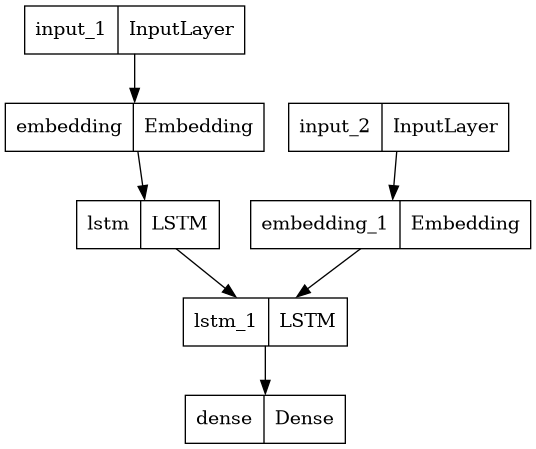

In [ ]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

plot_model(model)

In [ ]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 128
epochs = 50

In [ ]:
model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

/tmp/ipykernel_122306/2108290721.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
2023-03-18 19:35:25.416683: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 575373312 exceeds 10% of free system memory.


Epoch 1/50


2023-03-18 19:35:33.914148: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 575373312 exceeds 10% of free system memory.
2023-03-18 19:35:35.289024: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 575373312 exceeds 10% of free system memory.
2023-03-18 19:35:35.956447: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 575373312 exceeds 10% of free system memory.
2023-03-18 19:35:36.263440: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 575373312 exceeds 10% of free system memory.


   1/1323 [..............................] - ETA: 7:16:57 - loss: 10.0610 - acc: 0.0000e+00

In [ ]:
model.save_weights('files/model/nmt_weights.h5')
model.load_weights('files/model/nmt_weights.h5')

## Inference

In [ ]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs2] + decoder_states2)

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']
    
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char
        
        # Exit condition: either hit max length or find stop token.
        if (sampled_char == '_END' or len(decoded_sentence) > 50):
            stop_condition = True
        
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        
        # Update states
        states_value = [h, c]
    
    return decoded_sentence

## Evaluation on Train Dataset

In [ ]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

In [ ]:
for _ in range(15):
    k+=1
    (input_seq, actual_output), _ = next(train_gen)
    decoded_sentence = decode_sequence(input_seq)
    print('Input English sentence:', X_train[k:k+1].values[0])
    print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
    print('Predicted Marathi Translation:', decoded_sentence[:-4])